# Training a neural network on the MNIST Fashion dataset

In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

## Download data and create dataset objects

In [2]:

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

## Visualizing the Dataset
We can index Datasets manually like a list: `training_data[index]`.

img.shape:  torch.Size([1, 28, 28])
img.dtype:  torch.float32
img.device:  cpu
im1.shape: torch.Size([28, 28])
im2.shape:  torch.Size([1, 28, 28])


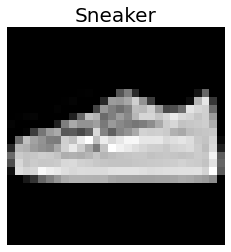

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

sample_idx = 108

img, label = training_data[sample_idx]
print('img.shape: ',  img.shape)
print('img.dtype: ',  img.dtype)
print('img.device: ', img.device) # Notice that the data is lying on the CPU. This is standard.

im1 = img.squeeze()
print('im1.shape:', im1.size())
im2 = im1.unsqueeze(0)
print('im2.shape: ', im2.shape)

plt.title(labels_map[label], fontsize=20)
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray")
plt.show()


## Create dataloaders
The `Dataset` retrieves our dataset’s features and labels one sample at a time. When training a model, we typically want to pass samples in “minibatches” and reshuffle the data at every epoch to reduce model overfitting and use Python’s `multiprocessing` to speed up data retrieval.




In [4]:
# Hyper-parameters
shuffle=True
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=shuffle)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

## Example: Iterate through the DataLoader




Input batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


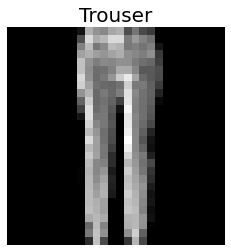

Label: 1


In [5]:
# Display image and label.
train_input, train_labels = next(iter(train_dataloader)) # Convert to iterable and get next element
print(f"Input batch shape: {train_input.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_input[0].squeeze()
label = int(train_labels[0])

plt.title(labels_map[label], fontsize=20)
plt.axis("off")
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Create model

In [6]:
from torch import nn

model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=60, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=60, out_channels=15, kernel_size=3,stride=2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(in_features=540, out_features=10, bias=True)
    )

print(model)

Sequential(
  (0): Conv2d(1, 60, kernel_size=(3, 3), stride=(2, 2))
  (1): ReLU()
  (2): Conv2d(60, 15, kernel_size=(3, 3), stride=(2, 2))
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=540, out_features=10, bias=True)
)


## Prepare the training

In [13]:
# Define a few hyperparameters
device = torch.device('cuda')
epochs = 5 # Number of iterations with stochastic gradient descent.
learning_rate = 0.003

loss_fn = nn.CrossEntropyLoss() # Define the loss funciton. It does not expect the input to be normalized
optimizer = torch.optim.SDG(model.parameters(), lr=learning_rate) # Choose the optimizer 
model = model.to(device) # Move model parameters to the device

AttributeError: module 'torch.optim' has no attribute 'SDG'

## Define the train loop

Inside the training loop, optimization happens in three steps:
 * Call `optimizer.zero_grad()` to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.
 * Backpropagate the prediction loss with a call to `loss.backward()`. PyTorch deposits the gradients of the loss w.r.t. each parameter.
 * Once we have our gradients, we call `optimizer.step()` to adjust the parameters by the gradients collected in the backward pass.

In [ ]:
def train_epoch(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    
    batch = 0
    for x, y in dataloader:
        # Compute prediction and loss
        batch = batch + 1
        
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def validation_epoch(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            
            val_loss += loss_fn(pred, y).item() # This is a float
            correct += (pred.argmax(1) == y).type(torch.float).sum()

    val_loss /= num_batches
    correct /= size
    print(f"Validataion Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")

## Start training

In [ ]:

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_epoch(train_dataloader, model, loss_fn, optimizer, device)
    validation_epoch(test_dataloader, model, loss_fn, device)
print("Done!")